Model 3 RNN 

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import preproc_RNN_LSTM
import pandas as pd
import plot_evaluate_models
import matplotlib.pyplot as plt
from metrics import get_baseline_data
import numpy as np
import math
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from baseline import get_baseline_actual, get_baseline_predictions, forecast_accuracy

# Import imput data

In [4]:
data =preproc_RNN_LSTM.get_baseline_data("raw_data/preproc_data_rate.csv")

# Set parameters

In [5]:
data.columns

Index(['Date', 'Anchieta', 'Bangu', 'Barra da Tijuca', 'Botafogo',
       'Campo Grande', 'Centro', 'Cidade de Deus', 'Complexo do Alemao',
       'Copacabana', 'Guaratiba', 'Ilha do Governador', 'Inhauma', 'Iraja',
       'Jacarepagua', 'Jacarezinho', 'Lagoa', 'Madureira', 'Mare', 'Meier',
       'Pavuna', 'Portuaria', 'Ramos', 'Realengo', 'Rio Comprido', 'Rocinha',
       'Santa Cruz', 'Santa Teresa', 'Sao Cristovao', 'Tijuca', 'Vila Isabel'],
      dtype='object')

In [21]:
n_sequences=3000
length=100
prediction_horizon = 31

# Modelling

## set training and test set

In [22]:
X_train, y_train, X_test, y_test = preproc_RNN_LSTM.get_train_test(data,n_sequences,length, prediction_horizon)

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 69, 30), (3000, 31, 30), (750, 69, 30), (750, 31, 30))

## define model

In [34]:
#model1 = preproc_RNN_LSTM.model(n_sequences, length-prediction_horizon, 30, prediction_horizon)

model1 = models.Sequential()
model1.add(layers.LSTM(128, return_sequences=False, activation="tanh", \
    input_shape = (length-prediction_horizon, 30)))
model1.add(layers.RepeatVector(prediction_horizon))
#model.add(Dropout(0.4))
model1.add(layers.LSTM(40, return_sequences=True, activation="tanh"))
model1.add(Dropout(0.4))

model1.add(layers.LSTM(10, return_sequences=True, activation="tanh"))

# added 
#model.add(BatchNormalization())
#model.add(Dropout(0.4))
model1.add(layers.TimeDistributed(layers.Dense(30,"relu")))
model1.compile(loss="mse",
            optimizer="rmsprop")

## train model

In [35]:
#preproc_RNN_LSTM.fit_model(X_train, y_train, model1)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20, restore_best_weights=True)
hist = model1.fit(X_train, y_train, 
                 callbacks=[es],
                 epochs = 2000,
                 validation_split =0.3, 
                 batch_size=16
                )

Epoch 1/2000
132/132 [==============================] - 9s 41ms/step - loss: 0.0490 - val_loss: 0.0449
Epoch 2/2000
132/132 [==============================] - 5s 35ms/step - loss: 0.0441 - val_loss: 0.0438
Epoch 3/2000
132/132 [==============================] - 5s 38ms/step - loss: 0.0428 - val_loss: 0.0438
Epoch 4/2000
132/132 [==============================] - 5s 35ms/step - loss: 0.0416 - val_loss: 0.0414
Epoch 5/2000
132/132 [==============================] - 5s 34ms/step - loss: 0.0406 - val_loss: 0.0405
Epoch 6/2000
132/132 [==============================] - 5s 38ms/step - loss: 0.0398 - val_loss: 0.0395
Epoch 7/2000
132/132 [==============================] - 6s 47ms/step - loss: 0.0386 - val_loss: 0.0394
Epoch 8/2000
132/132 [==============================] - 6s 45ms/step - loss: 0.0381 - val_loss: 0.0406
Epoch 9/2000
132/132 [==============================] - 6s 45ms/step - loss: 0.0372 - val_loss: 0.0386
Epoch 10/2000
132/132 [==============================] - 6s 44ms/step - l

Epoch 80/2000
132/132 [==============================] - 6s 47ms/step - loss: 0.0244 - val_loss: 0.0268
Epoch 81/2000
132/132 [==============================] - 6s 45ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 82/2000
132/132 [==============================] - 6s 43ms/step - loss: 0.0241 - val_loss: 0.0245
Epoch 83/2000
132/132 [==============================] - 6s 47ms/step - loss: 0.0239 - val_loss: 0.0277
Epoch 84/2000
132/132 [==============================] - 6s 43ms/step - loss: 0.0243 - val_loss: 0.0250
Epoch 85/2000
132/132 [==============================] - 6s 48ms/step - loss: 0.0239 - val_loss: 0.0264
Epoch 86/2000
132/132 [==============================] - 6s 45ms/step - loss: 0.0234 - val_loss: 0.0261
Epoch 87/2000
132/132 [==============================] - 7s 51ms/step - loss: 0.0234 - val_loss: 0.0275
Epoch 88/2000
132/132 [==============================] - 7s 56ms/step - loss: 0.0264 - val_loss: 0.0290
Epoch 89/2000
132/132 [==============================] - 8s 59ms

# Check outputs

## Check validation set

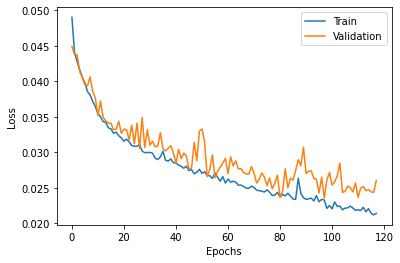

In [36]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.show()

## Check predicted vs actual on test set

In [37]:
y_pred = plot_evaluate_models.compute_pred_test(data,model1,length, prediction_horizon)

/Users/desireepetrilli/Documents/event-forecast-rio/baseline.py:19: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  baseline_mean = baseline_data.mean().to_frame().T


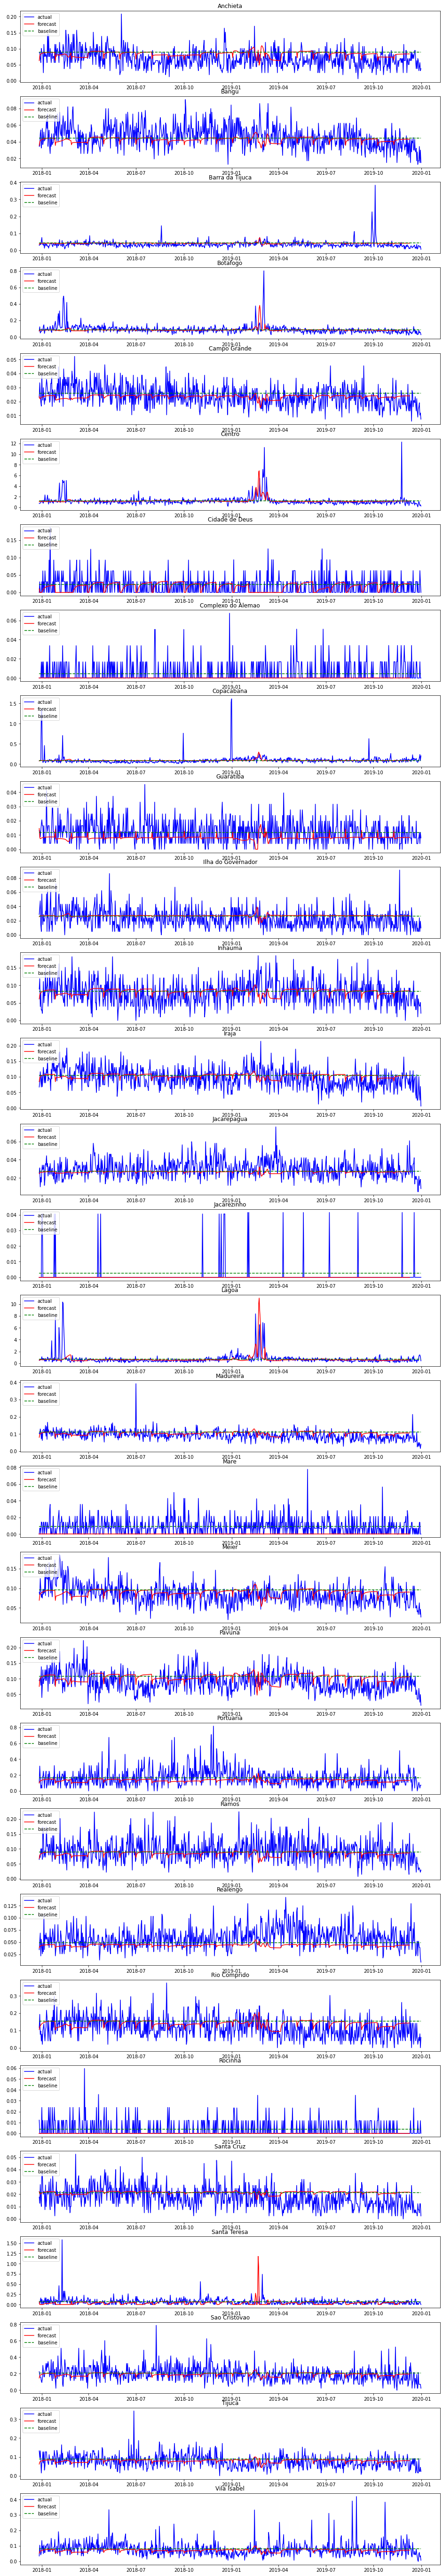

In [38]:
plot_evaluate_models.plot_actual_pred_test(data,model1, length, prediction_horizon)

In [39]:
error = plot_evaluate_models.error_actual_pred_baseline(data,y_pred,length, prediction_horizon)

/Users/desireepetrilli/Documents/event-forecast-rio/baseline.py:19: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  baseline_mean = baseline_data.mean().to_frame().T


In [40]:
error

,mae_baseline,mae_prediction
Anchieta,0.027359,0.025649
Bangu,0.010589,0.010824
Barra da Tijuca,0.014586,0.012798
Botafogo,0.028518,0.029644
Campo Grande,0.006256,0.005848
Centro,0.402029,0.397656
Cidade de Deus,0.021297,0.020726
Complexo do Alemao,0.007647,0.005511
Copacabana,0.042601,0.042417
Guaratiba,0.006022,0.006935


# save model!!

In [41]:
model1.save('models/allAR_3000_100_31')

2022-03-08 14:12:36.860002: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/allAR_3000_100_31/assets


INFO:tensorflow:Assets written to: models/allAR_3000_100_31/assets
